In [18]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
from scipy import stats # Статистика
from db_utils import get_connection

%matplotlib inline

In [19]:
connection = get_connection()

In [20]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-26' and '2022-10-02'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

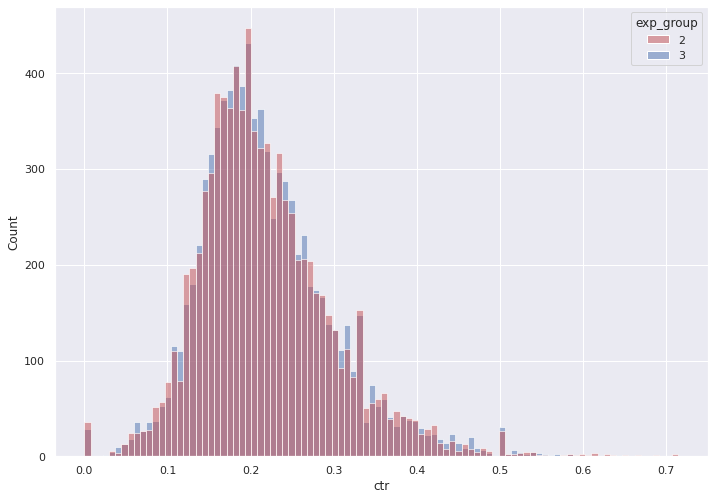

In [22]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [23]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.739359792495814, pvalue=0.45969873156477636)

In [24]:
pvalue_list = []
for _ in range(10000):
    group2_ctr = df[df.exp_group == 2].ctr.sample(500, replace=False)
    group3_ctr = df[df.exp_group == 3].ctr.sample(500, replace=False)
    pvalue_list.append(stats.ttest_ind(group2_ctr,
                group3_ctr,
                equal_var=False).pvalue)

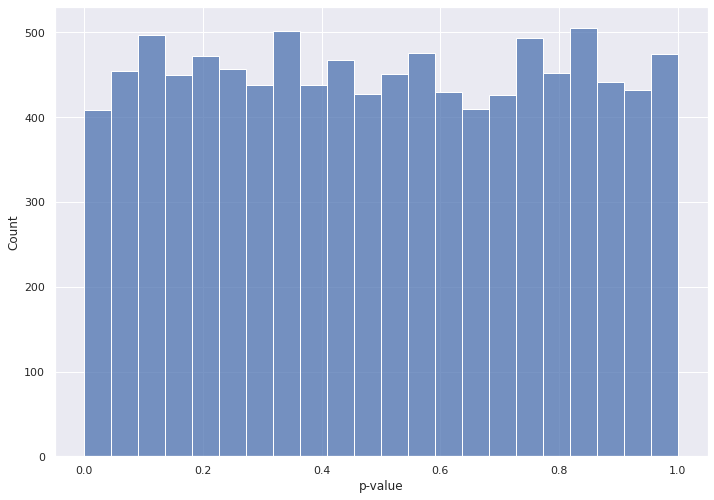

In [30]:
sns.histplot(pvalue_list)
_ = plt.xlabel('p-value')

In [26]:
k = 0
for i in range(len(pvalue_list)):
    if pvalue_list[i] <= 0.05:
        k += 1
print('В', k * 100 / len(pvalue_list),'% случаев p values оказались меньше либо равны 0.05')

В 4.45 % случаев p values оказались меньше либо равны 0.05


По результатам проведенного моделирования мы видим, что статистически значимые различия между двумя группами встречались в результате случайного ложного срабатывания только в 4.45% случаев, что достаточно близко к 5%. На этом основании можно сделать вывод, что система сплитования работает корректно.